In [2]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [15]:
results_file = f"MI_student2_dump0.pkl"
with open(results_file,'rb') as f:
    results = pkl.load(f)  
for i in range(1,4):
    results_file = f"MI_student_dump{i}.pkl"
    with open(results_file,'rb') as f:
        results += pkl.load(f)  
Ns = np.array([res[0][0] for res in results])
order = np.argsort(Ns)
results = [results[o] for o in order]
Ns = Ns[order]
Ns

array([ 2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  8,
        8,  8,  9,  9,  9, 10, 10, 10])

In [16]:
def line(ax,Ns,H,label,d=None,cut=Ns.max(),color=None):
    NN = cut+1-Ns.min()
    if d is None:
        d = np.zeros_like(H)
    A = np.empty((3,NN))
    for i in range(NN):
        n = Ns.min()+i
        A[0,i] = n
        if len(H[Ns==n])>0:
            A[1,i] = H[Ns==n].mean()
            A[2,i] = H[Ns==n].std() + d[Ns==n].mean()
        else:
            A[1:,i] = 0
    ax.plot(A[0],A[1],label=label,color=color)
    ax.fill_between(A[0],A[1]-A[2],A[1]+A[2],color='grey',alpha=0.2)

In [17]:
t = np.array([res[1][0][0] for res in results])
un = np.unique(t)
ns = [Ns[t==u][0] for u in un] 

In [18]:
import matplotlib.cm as cm

plt.figure(figsize=(3,3))
colors = cm.rainbow(np.linspace(0., 1., 10000))
plt.scatter(*(results[0]["y"][:,[0,1]]).T,color=colors,alpha=0.1)

TypeError: list indices must be integers or slices, not str

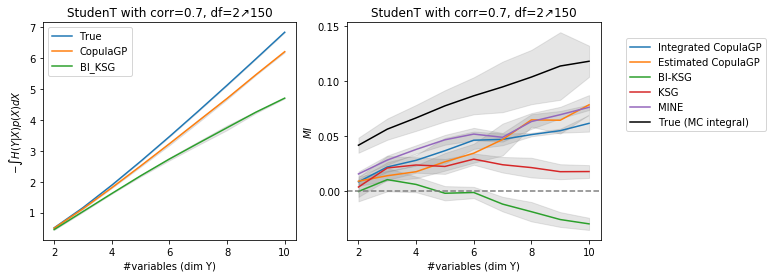

In [19]:
fig, (Hrs,Hr) = plt.subplots(1,2,figsize=(10,4))
    
for i,label in enumerate(["True","CopulaGP","BI_KSG"]):
    line(Hrs,Ns,np.array([res[2][i] for res in results]),label)
# line(np.array([res[2][-1]/Ns/2 for res in results]),"KSG")

for i,label in enumerate(["Integrated CopulaGP","Estimated CopulaGP","BI-KSG","KSG"]):
    line(Hr,Ns,np.array([res[1][2][i] for res in results]),label)
line(Hr,Ns,np.array([res[1][3][1] for res in results]),f"MINE")
# for i,H in enumerate([50,100,200,500,1000]):
#     line(ax[1],np.array([res[1][3][i] for res in results]),f"MINE H={H}")

# true
t = np.array([res[1][0][0] for res in results])
dt = np.array([res[1][0][1] for res in results])
ns = np.unique(Ns)
true = [ns,[t[Ns==n].mean() for n in ns],np.array([dt[Ns==n].mean() for n in ns])]
Hr.plot(true[0],true[1],label="True (MC integral)",color='black')
Hr.fill_between(true[0],true[1]-true[2]/2,true[1]+true[2]/2,color='grey',alpha=0.2)

for a in [Hrs,Hr]:
    a.set_title("StudenT with corr=0.7, df=2↗150")
    a.set_xlabel("#variables (dim Y)")
Hrs.set_ylabel("$-\int H(Y|X)p(X)dX$")
Hr.set_ylabel("$MI$")
Hr.set_yticks(np.arange(0.0,0.16,0.05))
Hrs.legend();
Hr.axhline(0,color='grey',linestyle='dashed')
Hr.legend(loc=(1.1,0.5));

In [20]:
# import sys
# home = '/home/nina/CopulaGP/'
# sys.path.insert(0, home)
# import utils
# NSamp=10000
# dfs = np.ones(NSamp)*10000
# rhos = np.linspace(-0.1,0.9,NSamp)
# true_H = []
# for Nvar in range(2,11):
#     HRgS = utils.student_H(rhos,dfs,Nvar)/np.log(2)
#     true_H.append(HRgS.mean())

In [21]:
results_file = f"rtGaussH_0.8_24.pkl"
with open(results_file,'rb') as f:
    results = pkl.load(f)  
results_file = f"rtGaussH_0.8_56.pkl"
with open(results_file,'rb') as f:
    results += pkl.load(f)  
for i in range(7,11):
    results_file = f"rtGaussH_0.8_{i}.pkl"
    with open(results_file,'rb') as f:
        results += pkl.load(f)  
Ns = np.array([res['Nvar'] for res in results])

fig, (Hrs,Hr) = plt.subplots(1,2,figsize=(9,4))

Hrs.plot(2,1)
line(Hrs,Ns,np.array([-res["eC"].mean() for res in results]),d = 0.01*Ns,label="CopulaGP",cut=Ns.max())
line(Hrs,Ns,np.array([-res["BI-KSG_H"] for res in results]),label="BI-KSG",cut=Ns.max())
# line(np.array([res[3][-1]/Ns/2 for res in results]),"KSG")

line(Hr,Ns,np.array([res["integrated"] for res in results]), d = 0.01*Ns, label="CopulaGP integrated",cut=Ns.max())
line(Hr,Ns,np.array([res["estimated"] for res in results]), 
         d=np.array([(results[-1]['gauss_eU'].std()+0.01*Ns*np.sqrt(2)) for res in results]),
     label="CopulaGP estimated",cut=Ns.max())
line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max())
line(Hr,Ns,np.array([res["KSG"] for res in results]),label="KSG",cut=Ns.max())
line(Hr,Ns,np.array([res["MINE100"] for res in results]),label="MINE100",cut=Ns.max())
line(Hr,Ns,np.array([res["MINE500"] for res in results]),label="MINE500",cut=Ns.max())

line(Hr,Ns,np.array([res["true_integral"] for res in results]),
     d = 0.01*Ns, label="True",cut=Ns.max(),color="black")

for a in [Hrs,Hr]:
    a.set_xlabel("#variables (dim Y)")
Hrs.set_ylabel("$-\int H(Y|X)p(X)dX$")
Hr.set_ylabel("$MI(X,Y)$")
Hr.set_title("Gauss with corr=-0.1↗0.8, $x_i = x_i + (\prod_{j=1}^{N} x_j)^{1/N}$")
Hrs.legend();
Hr.legend(loc=(1.1,0.5));

FileNotFoundError: [Errno 2] No such file or directory: 'rtGaussH_0.8_24.pkl'

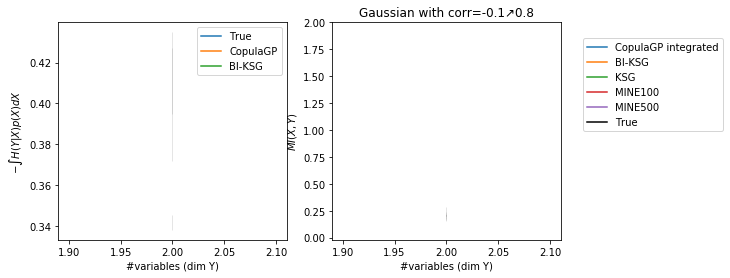

In [23]:
results_file = f"GaussH.pkl"
with open(results_file,'rb') as f:
    results = pkl.load(f)  
# results_file = f"GaussH_back.pkl"
# with open(results_file,'rb') as f:
#     results += pkl.load(f)   
Ns = np.array([res['Nvar'] for res in results])

fig, (Hrs,Hr) = plt.subplots(1,2,figsize=(9,4))

results[0]

line(Hrs,Ns,np.array([-res["eT"].mean() for res in results]),d = 0.01*Ns,label="True",cut=Ns.max())
line(Hrs,Ns,np.array([-res["eC"].mean() for res in results]),d = 0.01*Ns,label="CopulaGP",cut=Ns.max())
line(Hrs,Ns,np.array([-res["BI-KSG_H"] for res in results]),label="BI-KSG",cut=Ns.max())
# line(np.array([res[3][-1]/Ns/2 for res in results]),"KSG")

line(Hr,Ns,np.array([res["integrated"] for res in results]), d = 0.01*Ns, label="CopulaGP integrated",cut=Ns.max())
# line(Hr,Ns,np.array([res["estimated"] for res in results]), 
#          d=np.array([(results[-1]['eU'].std()+0.01*Ns*np.sqrt(2)) for res in results]),
#      label="CopulaGP estimated",cut=Ns.max())
line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max())
line(Hr,Ns,np.array([res["KSG"] for res in results]),label="KSG",cut=Ns.max())
line(Hr,Ns,np.array([res["MINE100"] for res in results]),label="MINE100",cut=Ns.max())
line(Hr,Ns,np.array([res["MINE500"] for res in results]),label="MINE500",cut=Ns.max())

line(Hr,Ns,np.array([res["true_integral"] for res in results]),
     d = 0.01*Ns, label="True",cut=Ns.max(),color="black")

for a in [Hrs,Hr]:
    a.set_xlabel("#variables (dim Y)")
Hrs.set_ylabel("$-\int H(Y|X)p(X)dX$")
Hr.set_ylabel("$MI(X,Y)$")
Hr.set_title("Gaussian with corr=-0.1↗0.8")
Hr.set_ylim(-0.02,2.0)
Hrs.legend();
Hr.legend(loc=(1.1,0.5));

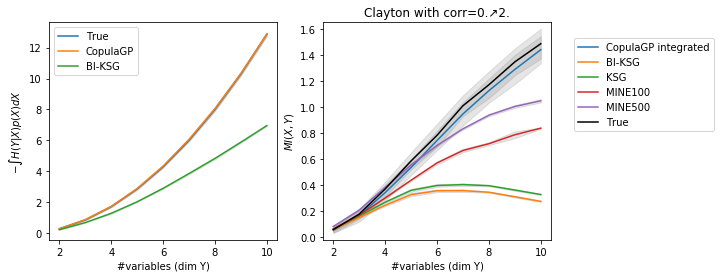

In [93]:
results_file = f"ClaytonH.pkl"
with open(results_file,'rb') as f:
    results = pkl.load(f)  
results_file = f"ClaytonH_back.pkl"
with open(results_file,'rb') as f:
    results += pkl.load(f)   
Ns = np.array([res['Nvar'] for res in results])

fig, (Hrs,Hr) = plt.subplots(1,2,figsize=(9,4))

results[0]

line(Hrs,Ns,np.array([-res["eT"].mean() for res in results]),d = 0.01*Ns,label="True",cut=Ns.max())
line(Hrs,Ns,np.array([-res["eC"].mean() for res in results]),d = 0.01*Ns,label="CopulaGP",cut=Ns.max())
line(Hrs,Ns,np.array([-res["BI-KSG_H"] for res in results]),label="BI-KSG",cut=Ns.max())
# line(np.array([res[3][-1]/Ns/2 for res in results]),"KSG")

line(Hr,Ns,np.array([res["integrated"] for res in results]), d = 0.01*Ns, label="CopulaGP integrated",cut=Ns.max())
# line(Hr,Ns,np.array([res["estimated"] for res in results]), 
#          d=np.array([(results[-1]['eU'].std()+0.01*Ns*np.sqrt(2)) for res in results]),
#      label="CopulaGP estimated",cut=Ns.max())
line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max())
line(Hr,Ns,np.array([res["KSG"] for res in results]),label="KSG",cut=Ns.max())
line(Hr,Ns,np.array([res["MINE100"] for res in results]),label="MINE100",cut=Ns.max())
line(Hr,Ns,np.array([res["MINE500"] for res in results]),label="MINE500",cut=Ns.max())

line(Hr,Ns,np.array([res["true_integral"] for res in results]),
     d = 0.01*Ns, label="True",cut=Ns.max(),color="black")

for a in [Hrs,Hr]:
    a.set_xlabel("#variables (dim Y)")
Hrs.set_ylabel("$-\int H(Y|X)p(X)dX$")
Hr.set_ylabel("$MI(X,Y)$")
Hr.set_title("Clayton with corr=0.↗2.")
Hr.set_ylim(-0.02,1.65)
Hrs.legend();
Hr.legend(loc=(1.1,0.5));